##  Hauptskript mit allen Modellen und Preprocessing

In [ ]:
import torch.nn as nn
import pandas as pd
import numpy as np
from matplotlib import pyplot
import torch
import yfinance as yf
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns 
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from sklearn.preprocessing import MinMaxScaler
import lightning as L
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
from keras import ops
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
file_path = 'data\BB_Rates_15min_from_10-2023.xlsx'
data = pd.read_excel(file_path)


### Datenvorverarbeitung der Trainingsdaten

In [ ]:
start_index = 3
EURUSD = data.iloc[start_index:, :2]

# Rename the columns
EURUSD.columns = ['Dates', 'Close']
# Convertiere 'Dates' spalte zu Datetime format
EURUSD['Dates'] = pd.to_datetime(EURUSD['Dates'])
#EURUSD.head()


In [ ]:
# Convertiere 'Dates' spalte zu Datetime format
EURUSD['Dates'] = pd.to_datetime(EURUSD['Dates'])
time_interval = pd.Timedelta(minutes=15)
# Calculate the difference between consecutive dates
EURUSD['TimeDiff'] = EURUSD['Dates'].diff()

# Identify the sections with consecutive 15-minute intervals
EURUSD['IsConsecutive'] = EURUSD['TimeDiff'] == time_interval
EURUSD['Block'] = (EURUSD['IsConsecutive'] != EURUSD['IsConsecutive'].shift()).cumsum()

In [ ]:
# Filter out sections with fewer than 2 days of consecutive 15-minute observations
min_consecutive_minutes = 2 * 24 * 60  # 2 days in minutes
valid_blocks = EURUSD.groupby('Block').filter(lambda x: len(x) >= min_consecutive_minutes / 15).Block.unique()
EURUSD_filtered = EURUSD[EURUSD['Block'].isin(valid_blocks)]

# Add the observation timeframe column
EURUSD_filtered['TimeFrame'] = EURUSD_filtered.groupby('Block').cumcount() + 1

# Drop the 'TimeDiff' and 'IsConsecutive' columns as they are no longer needed
EURUSD_filtered = EURUSD_filtered.drop(columns=['TimeDiff', 'IsConsecutive'])

# Display the first few rows of the filtered dataset with the new 'Block' and 'TimeFrame' columns
print(EURUSD_filtered.head())

In [ ]:
block_mapping = {old_block: new_block for new_block, old_block in enumerate(EURUSD_filtered['Block'].unique(), 1)}

In [ ]:
EURUSD_filtered = EURUSD_filtered.reset_index(drop=True)
EURUSD_filtered = EURUSD_filtered.drop(columns=['TimeFrame'])
EURUSD_filtered.head()

In [207]:
## erzeugt Samples aus den einzelnen Blöcken zusammenhängender Zeitreihen
def create_dataset(lookback, forecast_horizon, data):
        X, Y = [], []
        scaler = MinMaxScaler(feature_range = (0, 1))
        for i in range(len(data) - lookback - forecast_horizon + 1):
            if data.iloc[i]['Block'] == data.iloc[i + lookback + forecast_horizon - 1]['Block']:
                X_values = data.iloc[i:i+lookback]['Close'].values
                Y_values = data.iloc[i+lookback:i+lookback+forecast_horizon]['Close'].values
                X_scaled = scaler.fit_transform(X_values.reshape(-1, 1))
                Y_scaled = scaler.transform(Y_values.reshape(-1, 1))
                X.append(X_scaled)
                Y.append(Y_scaled)
        return np.array(X), np.array(Y), scaler

##aktuell: lookback = 60 Zeitschritte, forecast_horizon = 1
X, Y, scaler = create_dataset(lookback=96, forecast_horizon=4, data=EURUSD_filtered)

In [208]:

x_train,y_train = np.array(X), np.array(Y)
x_train= np.reshape(x_train,( x_train.shape[0] ,x_train.shape[1] ,1))

### Modell 1: Keras Stacked LSTM für Punktvorhersagen

In [209]:
##Keras LSTM Modell das ganz gut performt
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM( 50, return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')


C:\Users\nilsw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [210]:
##training
model.fit(x_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - loss: 0.0669
Epoch 2/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - loss: 0.0295
Epoch 3/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 0.0262
Epoch 4/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - loss: 0.0272
Epoch 5/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - loss: 0.0241
Epoch 6/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 0.0244
Epoch 7/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - loss: 0.0240
Epoch 8/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - loss: 0.0247
Epoch 9/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - loss: 0.0255
Epoch 10/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - loss: 0.0225


### Modell 2: Lightning Stacked LSTM mit Probabiltischen Output

In [220]:
### Einfaches Probabilistisches LSTM mit lightining-torch
class LSTM_Modell(L.LightningModule):
    def __init__(self):
        super(LSTM_Modell, self).__init__()
        self.lstm = nn.LSTM(1, 50, 2, batch_first=True)
        self.dropout = nn.Dropout(0.2)  # Dropout layer hinzufügen
        self.fc1 = nn.Linear(50, 25)
        self.fc_mean = nn.Linear(25, 1)
        self.fc_log_var = nn.Linear(25, 1)
        self.loss = nn.GaussianNLLLoss()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])  # Dropout auf den letzten LSTM-Ausgabewert anwenden
        x = torch.relu(self.fc1(x))  # ReLU-Aktivierungsfunktion nach der ersten Dense-Schicht anwenden
        mean = self.fc_mean(x)
        log_var = self.fc_log_var(x)
        var = torch.exp(log_var)  # sorgt für pos varianz
        return mean, var #gibt mean und varianz zurück

    def training_step(self, batch, batch_idx):
        x, y = batch
        mean, var = self(x)
        loss = self.loss(mean, y, var)
        self.log('train_loss', loss)
        print(loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

    def predict_step(self, batch, batch_idx):
        x, y = batch
        mean, var = self(x)
        lower_bound = mean - 1.96 * torch.sqrt(var)  # 95% confidence interval lower bound
        upper_bound = mean + 1.96 * torch.sqrt(var)  # 95% confidence interval upper bound
        return lower_bound, upper_bound  



In [219]:
lstm_modell = LSTM_Modell()
dataset = utils.data.TensorDataset(Tensor(x_train), Tensor(y_train))
train_loader = utils.data.DataLoader(dataset, batch_size=32)

In [221]:
trainer = L.Trainer(limit_train_batches=32, max_epochs=10)
trainer.fit(model=lstm_modell, train_dataloaders=train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name       | Type            | Params | Mode 
-------------------------------------------------------
0 | lstm       | LSTM            | 31.0 K | train
1 | dropout    | Dropout         | 0      | train
2 | fc1        | Linear          | 1.3 K  | train
3 | fc_mean    | Linear          | 26     | train
4 | fc_log_var | Linear          | 26     | train
5 | loss       | GaussianNLLLoss | 0      | train
-------------------------------------------------------
32.3 K    Trainable params
0         Non-trainable params
32.3 K    Total params
0.129     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s] Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\nilsw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\nilsw\AppData\Local\Temp\ipykernel_788\1734855294.py", line 2, in <module>
    trainer.fit(model=lstm_modell, train_dataloaders=train_loader)
  File "C:\Users\nilsw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\trainer.py", line 543, in fit
    call._call_and_handle_interrupt(
  File "C:\Users\nilsw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\call.py", line 44, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File 

###  Testen

In [149]:
##neue Forexzeitreihen von yahoo finance gezogen zum testen

new = yf.download(tickers ='EURUSD=X',start ='2024-06-01',end ='2024-06-29',interval= '15m' )
new = new.filter(['Close'])
new_dataset = new.values
new_data = scaler.transform(new_dataset)
test = []
for i in range(60,len(new_data)):
    test.append(new_data[i-60:i,0])
test = np.array(test)
test = np.reshape(test, (test.shape[0],test.shape[1],1))
##predictions vom keras modell
new_predictions = model.predict(test)

test = torch.tensor(test).float()
lstm_modell.eval()
with torch.no_grad():
    mu, var = lstm_modell(test)
    
mu = mu.numpy()
var = var.numpy()
#print(var)
## zurückskalieren 
new_predictions = scaler.inverse_transform(new_predictions)
new_data = scaler.inverse_transform(new_data)
mu = scaler.inverse_transform(mu)
var = scaler.inverse_transform(np.sqrt(var))

[*********************100%%**********************]  1 of 1 completed

14/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


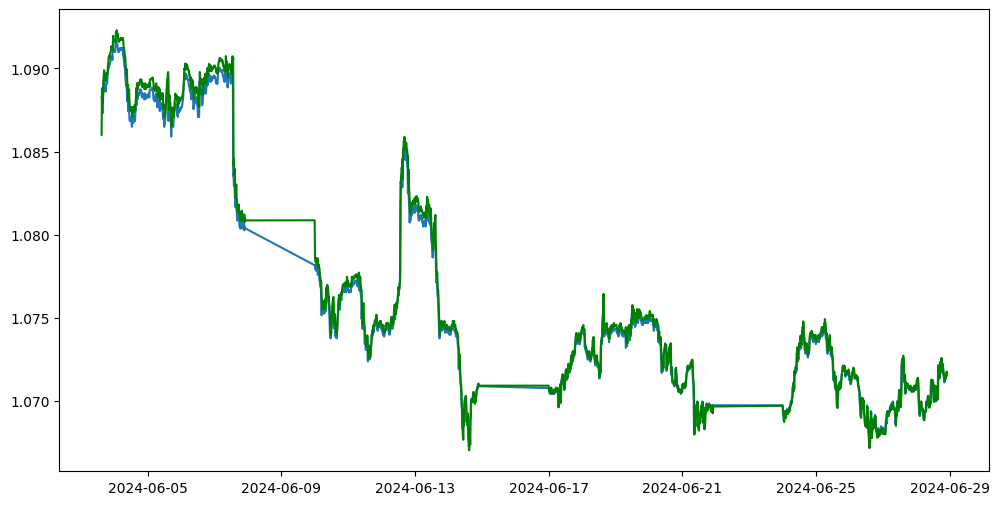

In [150]:

# Plot-Funktion


plt.figure(figsize=(12, 6))  # Setze die Größe des Plots

# Plot der tatsächlichen Daten ab dem 60. Zeitschritt (wegen lookback=60)
plt.plot(new.index[60:], new_data[60:], label='Actual Data')


# Plot der Vorhersagen (Mittelwerte)
#plt.plot(new.index[60:], mu[:,9], label='Prediction Mean', color='red')
plt.plot(new.index[60:], new_predictions, label='Prediction', color='green')

# Plot des Konfidenzintervalls (ganz viel bullshit)
#lower_bound = mu.flatten() - 1.96 * var.flatten()  # 95% confidence interval lower bound
#upper_bound = mu.flatten() + 1.96 * var.flatten()  # 95% confidence interval upper bound
#plt.fill_between(new.index[60:], lower_bound, upper_bound, color='gray', alpha=0.02, label='95% Confidence Interval')



In [74]:
print(upper_bound)
print(var)

[3.189567  3.189571  3.1895733 ... 3.1897743 3.1897745 3.189774 ]
[[1.0765406]
 [1.0765028]
 [1.076468 ]
 ...
 [1.078129 ]
 [1.0781264]
 [1.0781238]]


## Keras LSTM-VAE Modell

In [226]:
latent_dim = 2
hidden = 30 

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

##encoder
encoder_inputs = keras.Input(shape= (x_train.shape[1], 1))
x = layers.LSTM(hidden, return_sequences=True)(encoder_inputs)
#x = layers.LSTM(hidden, return_sequences=True)(x)
#x = layers.LSTM(hidden, return_sequences=True)(x)
x = layers.LSTM(hidden, return_sequences=False)(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

##decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(100)(latent_inputs)
x = layers.RepeatVector(x_train.shape[1])(x)
x = layers.LSTM(100, return_sequences=True)(x)
x = layers.LSTM(100, return_sequences=True)(x)
decoder_outputs = layers.TimeDistributed(Dense(1))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 96, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_52 (LSTM)      │ (None, 96, 70)    │     20,160 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_53 (LSTM)      │ (None, 70)        │     39,480 │ lstm_52[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 1)         │         71 │ lstm_53[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 1)         │         71 │ lstm_53[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_9          │ (None, 1)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 59,782 (233.52 KB)

 Trainable params: 59,782 (233.52 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 100)            │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_7 (RepeatVector)  │ (None, 96, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_54 (LSTM)                  │ (None, 96, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 96, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 96, 1)          │           101 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,101 (629.30 KB)

 Trainable params: 161,101 (629.30 KB)

 Non-trainable params: 0 (0.00 B)

In [227]:
##lstm vae modell in Keras

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed, z_mean, z_log_var
    
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis= 1,
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": total_loss}

In [228]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [229]:
vae.fit(x_train, epochs=20, batch_size=200)


Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 763ms/step - loss: 124.0477
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 721ms/step - loss: 69.5717
Epoch 3/20
20/53 ━━━━━━━━━━━━━━━━━━━━ 20s 631ms/step - loss: 69.2020

KeyboardInterrupt: 

### Testing

In [206]:
##neue Forexzeitreihen von yahoo finance gezogen zum testen

new = yf.download(tickers ='EURUSD=X',start ='2024-06-01',end ='2024-06-29',interval= '15m' )
new = new.filter(['Close'])
new_dataset = new.values
new_data = scaler.transform(new_dataset)
test = []
for i in range(60,len(new_data)):
    test.append(new_data[i-60:i,0])
test = np.array(test)
test = np.reshape(test, (test.shape[0],test.shape[1],1))


test = torch.tensor(test).float()
lstm_modell.eval()
with torch.no_grad():
    pred, mu, log_var  = vae(test)
    
mu = mu.numpy()
#var = var.numpy()
var = np.exp(var)
print('Var',var)
## zurückskalieren 
new_predictions = scaler.inverse_transform(new_predictions)
mu = scaler.inverse_transform(mu)
var = scaler.inverse_transform(np.sqrt(var))
new_data = scaler.inverse_transform(new_data)

[*********************100%%**********************]  1 of 1 completed


Var [[3.0327342 3.0327375 3.032751  ... 3.0327253 3.0323253 3.0319471]
 [3.0327342 3.0327382 3.032751  ... 3.0327249 3.0323238 3.0319455]
 [3.0327342 3.0327382 3.0327508 ... 3.0327246 3.0323215 3.031944 ]
 ...
 [3.0327113 3.0327299 3.0327156 ... 3.0327523 3.032526  3.032061 ]
 [3.032712  3.0327299 3.0327156 ... 3.0327528 3.0325243 3.03206  ]
 [3.0327122 3.0327299 3.0327158 ... 3.032753  3.0325224 3.032059 ]]


In [202]:
print(var)

[[1.1094645 1.1094657 1.1094702 ... 1.1094617 1.1093297 1.109205 ]
 [1.1094645 1.109466  1.1094702 ... 1.1094615 1.1093292 1.1092045]
 [1.1094645 1.109466  1.1094701 ... 1.1094614 1.1093285 1.109204 ]
 ...
 [1.109457  1.1094632 1.1094584 ... 1.1094706 1.109396  1.1092426]
 [1.1094573 1.1094632 1.1094584 ... 1.1094707 1.1093954 1.1092422]
 [1.1094574 1.1094632 1.1094586 ... 1.1094708 1.1093948 1.109242 ]]


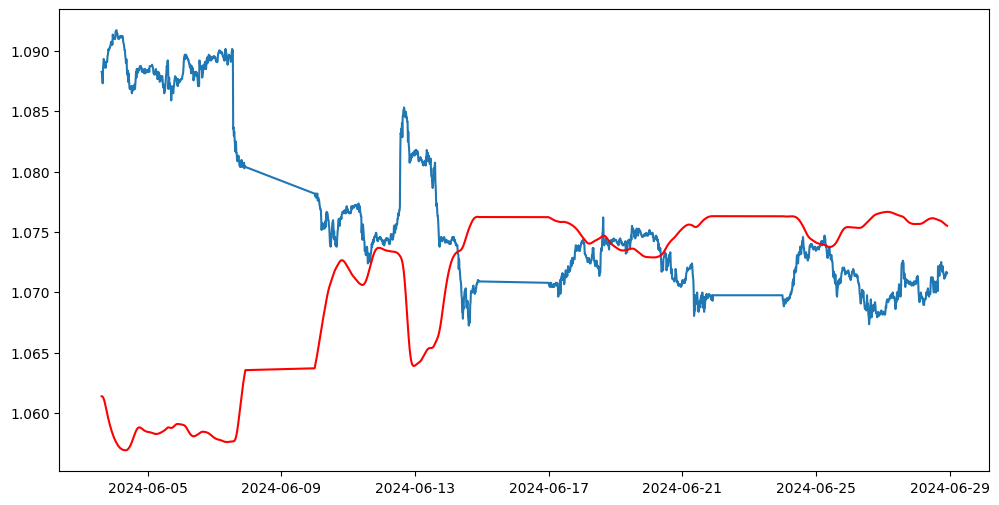

In [204]:

# Plot-Funktion


plt.figure(figsize=(12, 6))  # Setze die Größe des Plots

# Plot der tatsächlichen Daten ab dem 60. Zeitschritt (wegen lookback=60)
plt.plot(new.index[60:], new_data[60:], label='Actual Data')
#plt.plot(new.index[60:], pred, label='Prediction', color='green')

#print(mu.shape)
# Plot der Vorhersagen (Mittelwerte)
plt.plot(new.index[60:], mu[:,9], label='Prediction Mean 1', color='red')
#plt.plot(new.index[60:], mu, label='Prediction Mean 3', color='red')

# Plot des Konfidenzintervalls (ganz viel bullshit)
lower_bound = mu[:,9] - 1.96 * var[:,9]  # 95% confidence interval lower bound
upper_bound = mu[:,9] + 1.96 * var[:,9]  # 95% confidence interval upper bound
#plt.plot(new.index[60:], lower_bound, color='green')
##plt.plot(new.index[60:], upper_bound, color='green')
#plt.fill_between(new.index[60:], lower_bound, upper_bound, color='green', alpha=0.4, label='95% Confidence Interval')